In [1]:
from configs.config import config
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'    # GPU No.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

from sampler.utils import *
from trainer.utils import restore_checkpoint
import torch
import torch.nn as nn
import scipy.io
import sys

from torch.utils.data import DataLoader
from tqdm import tqdm

from models.unet_video import UNetVideoModel
from models.ema import ExponentialMovingAverage
from sampler import VESDE
import numpy as np
from einops import rearrange

2024-04-29 19:50:41.560824: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 19:50:41.615540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 19:50:42.467868: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load pretrained model and test data

In [2]:
config.cuda = config.gpu is not None
if config.cuda:
    device = 'cuda'
else:
    device = 'cpu'

checkpoint_path = '/data/kol/checkpoint_ns4_kolmogorov_video_v0.pth'
data_test_path = '/data/kol/data_test_ns4.npy'
scalar_path = '/data/kol/scalar_ns4_kolmogorov_video_v0.npy'
config.version = 'kolmogorov_video_v0'
config.sample_mode = 'experiment'
config.num_samples_train = 100000
config.batch_size = 32
config.num_conditions = 2
config.num_frames = 10          
config.num_components = 2
config.image_size = 64
config.dimension = config.image_size ** 2 * (config.num_frames + config.num_conditions)
config.num_channels = config.num_components + config.num_conditions
config.channel_modal = [config.num_frames*config.num_components, 1, 1]
config.num_modals = len(config.channel_modal)
net = UNetVideoModel(config.num_channels, model_channels=32, out_channels=config.num_channels, 
                         num_res_blocks=2, 
                         attention_resolutions=(8, 16), 
                         image_size=config.image_size, 
                         dropout=0.1, 
                         channel_mult=(1, 2, 4, 8),
                         conv_resample=True,
                         dims=2,
                         num_heads=1,
                         use_rpe_net=True)

net = nn.DataParallel(net)
net.to(device)
ema = ExponentialMovingAverage(net.parameters(), decay=config.ema_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=config.lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
state = dict(optimizer=optimizer, model=net, ema=ema, epoch=0, iteration=0)

state = restore_checkpoint(checkpoint_path, state, device)
net = state['model']
optimizer = state['optimizer']
ema = state['ema']

data_raw = np.load(data_test_path)
rey = np.array([50, 125, 575, 1100, 1500])
sigma = np.array([2, 4, 6, 8])
_, z = np.meshgrid(np.linspace(0, 2 * np.pi, config.image_size, endpoint=False),
                    np.linspace(0, 2 * np.pi, config.image_size, endpoint=False), indexing='ij')
x_test = data_raw.reshape(5, -1, 400, 64, 64, 2)
mean, std = np.load(scalar_path)
scalar = lambda x: (x-mean)/std
scalar_inv = lambda x: x*std+mean

# Sample test data from the test dataset

In [3]:
config.overlap = 2
config.num_steps = 50       # length of frames you want to generate

samples = []
seed_samples = 1
rnd = np.random.RandomState(seed_samples)
num_re = len(x_test)
num_k = len(x_test[0])
s_re, s_k = 4, 0

nf = config.num_frames
ns = config.num_steps
ol = config.overlap
b = int(ns // (nf - ol) + 1)  # the number of samples that need to generate
ns_real = b * (nf - ol) + ol

config.channel_modal = None

'''experimental samples'''
indices = []
for i_re, tr_k in enumerate(x_test):
    for i_k, tr in enumerate(tr_k):
        rnd = np.random.RandomState(seed_samples+i_re*num_re+i_k)
        i_steps = rnd.choice(len(tr) - config.num_frames - ns_real - 10,
                                config.num_samples, replace=False)+10
        indices.append(i_steps)
        for i in i_steps:
            single_sample = x_test[i_re, i_k, i:i + ns_real].transpose(0, 3, 1, 2)
            f = np.sin(sigma[i_k] * z)[np.newaxis, np.newaxis].repeat(ns_real, axis=0)
            r = (1./rey[i_re]*100. * np.ones_like(f))
            if config.num_conditions == 1:
                samples.append(np.concatenate([single_sample, f*1./rey[i_re]*100.], axis=1))
            else:
                samples.append(np.concatenate([single_sample, f, r], axis=1))
samples = np.stack(samples, axis=0)         # b*(t*c+2)*h*w
indices = np.array(indices).reshape(num_re, num_k, -1)
samples = samples[[s_re*num_k+s_k]]

# Reconstruction

In [4]:
outer_loop = 200    # predictor steps
inner_loop = 5      # corrector steps

mask_ratio = 0.95
noise_level = 0.

seed_sample = 666  # performance is affected by the noise added to the sampling path

# guidance coefficients (may vary for different samples)
alpha = 3.      # observation guidance
gamma1 = 0.05   # sequence consistency guidance
gamma2 = 0.05   # parameter consistency guidance

'''for Kolmogorov flow'''
domain_size = 2*np.pi
spacing = domain_size/config.image_size
offsets = np.array([0., 0.])
sde = VESDE(config, sigma_min=config.beta_min, sigma_max=config.beta_max, N=outer_loop)
net.eval()
reap_fn = lambda x, num: torch.stack([x for _ in range(num)])

setup_seed(seed_sample)
with torch.no_grad():
    '''random points'''
    mask = np.zeros([config.num_channels, config.image_size, config.image_size])
    mask[:config.num_components] = mask_gen([1, config.image_size, config.image_size], mask_ratio, seed=seed_samples)
    mask_torch = torch.from_numpy(mask).to(device)
    transform_gen = transform = lambda x:x*mask[np.newaxis, np.newaxis] if isinstance(x, np.ndarray) else x*mask_torch[None, None]  # define your own observations!
    '''parameter conditioned'''
    # transform_gen = transform = lambda x:x[:, :10, :config.num_components]
    
    samples_scale = samples.copy()
    samples_scale[:, :, :config.num_components] = scalar(samples_scale[:, :, :config.num_components])
    y = transform_gen(samples_scale+np.random.randn(*samples_scale.shape)*noise_level)
    print(y.shape)

    latent_mask = torch.stack([torch.ones([config.num_frames, 1, 1, 1]).float() for _ in range(len(y))]).to(device)
    obs_mask = torch.stack([torch.zeros([config.num_frames, 1, 1, 1]).float() for _ in range(len(y))]).to(device)
    frame_indices = torch.stack([torch.arange(config.num_frames) for _ in range(len(y))]).to(device)
    latent_mask = torch.ones([config.num_frames, 1, 1, 1]).float().to(device)
    obs_mask = torch.zeros([config.num_frames, 1, 1, 1]).float().to(device)
    frame_indices = torch.arange(config.num_frames).to(device)
    if isinstance(net.module, UNetVideoModel):
        net_fn = lambda x, t: net(x, x0=x, timesteps=t, latent_mask=reap_fn(latent_mask, len(x)), obs_mask=reap_fn(obs_mask, len(x)), frame_indices=reap_fn(frame_indices, len(x)))[0]
    else:
        def net_fn(x, t):
            h = net(torch.cat([rearrange(x[:, :, :config.num_components], 'b t c h w -> b (t c) h w'), x[:, 0, config.num_components:]], dim=1), t)
            h1 = rearrange(h[:, :-config.num_conditions], 'b (t c) h w -> b t c h w', c=config.num_components)
            return torch.cat([h1, h[:, None, -config.num_conditions:].repeat(1, len(h1[0]), 1, 1, 1)], dim=2)

    x_inpainted, x_generated = complete_video_pc_dps(config, net_fn, sde, y,
                                                        transform_gen,
                                                        alpha=alpha, beta=0, gamma1=gamma1, gamma2=gamma2,
                                                        corrector=LangevinCorrector,
                                                        snr=0.128, save_sample_path=True,
                                                        n_steps=inner_loop,
                                                        device=device, dtype='float', eps=1e-12,
                                                        probability_flow=False, continuous=True,
                                                        data_scalar=scalar)

x_pred = x_inpainted
x_pred[:, :, :config.num_components] = scalar_inv(x_pred[:, :, :config.num_components])
vor_pred = vor_cal_batch(np.concatenate([x_pred[0, :, 1:2], x_pred[0, :, :1]], axis=1), config.image_size, [0, domain_size])
vor_ref = vor_cal_batch(np.concatenate([samples[0, :, 1:2], samples[0, :, :1]], axis=1), config.image_size, [0, domain_size])
print(x_pred.shape)

(1, 58, 4, 64, 64)


100%|██████████| 200/200 [04:36<00:00,  1.38s/it]

(1, 58, 4, 64, 64)


# Visualization
Comparison between generated samples and the reference

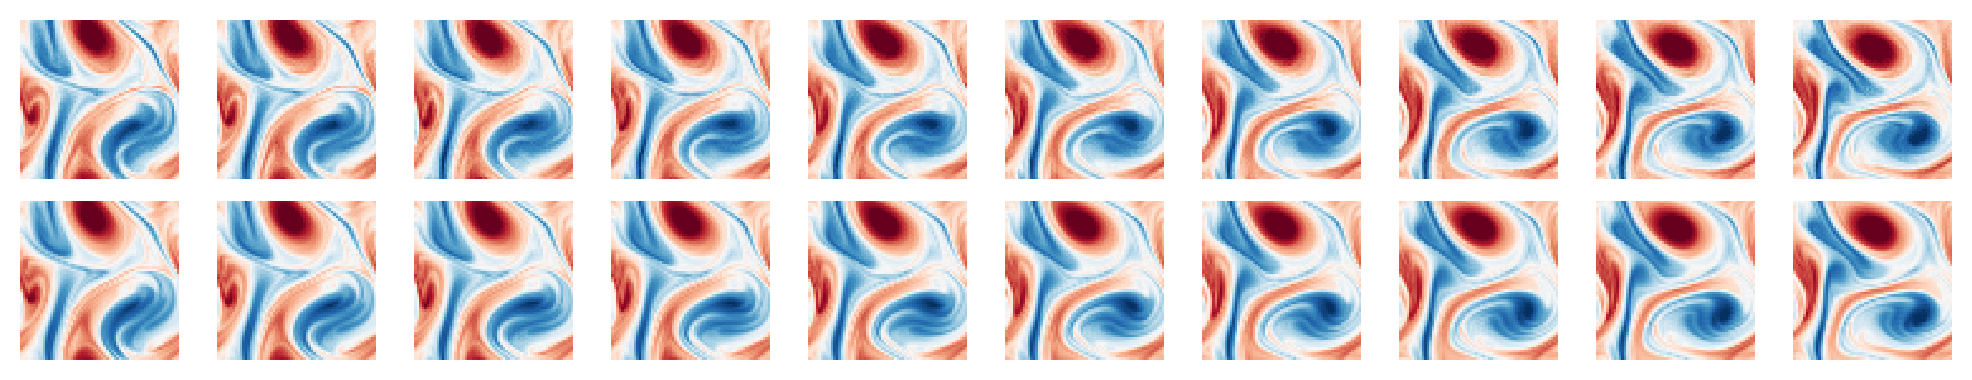

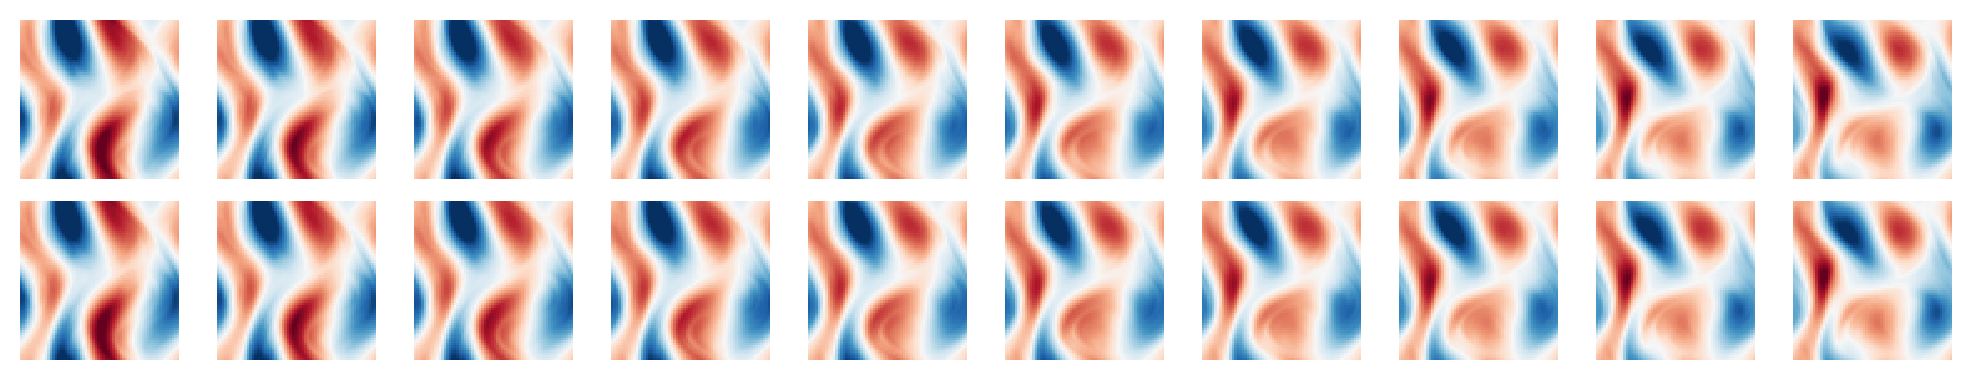

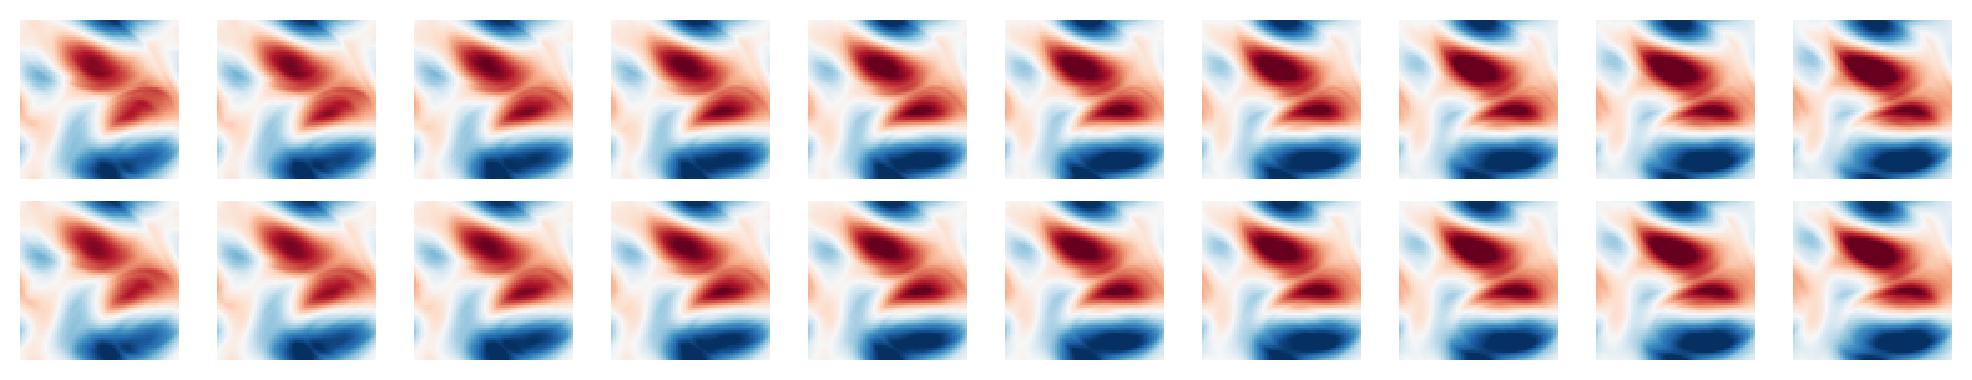

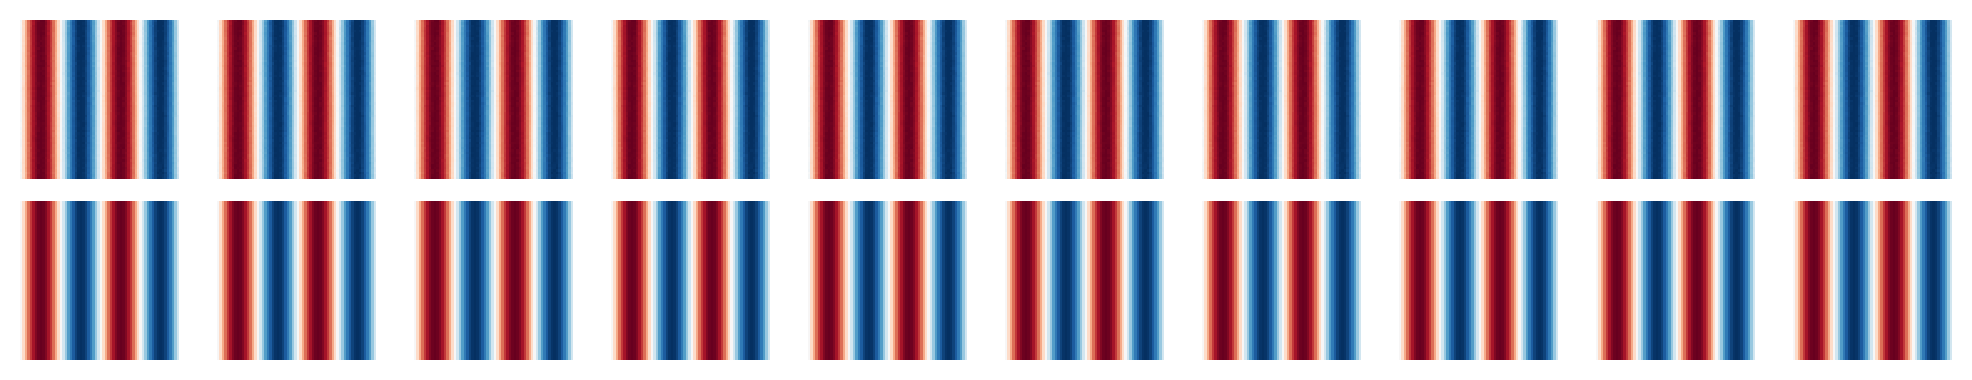

In [6]:
%matplotlib inline
from einops import rearrange
i_start = 40
length  = 10
plot_field(np.concatenate([vor_pred[i_start:i_start+length, :63, :63], vor_ref[i_start:i_start+length]]), 2, length, dpi=200, q_range=[-8, 8])  # vorticity field calculated from the velocity
plot_field(np.concatenate([x_pred[0, i_start:i_start+length, 0], samples[0, i_start:i_start+length, 0]]), 2, length, dpi=200, q_range=[-3, 3])  # 1st component of velocity
plot_field(np.concatenate([x_pred[0, i_start:i_start+length, 1], samples[0, i_start:i_start+length, 1]]), 2, length, dpi=200, q_range=[-3, 3])  # 2nd component of velocity
plot_field(np.concatenate([x_pred[0, i_start:i_start+length, 2], samples[0, i_start:i_start+length, 2]]), 2, length, dpi=200, q_range=[-1, 1])  # source term

# GIF of the generated field
Please check '../results/test_kol.gif' for the generated GIF!

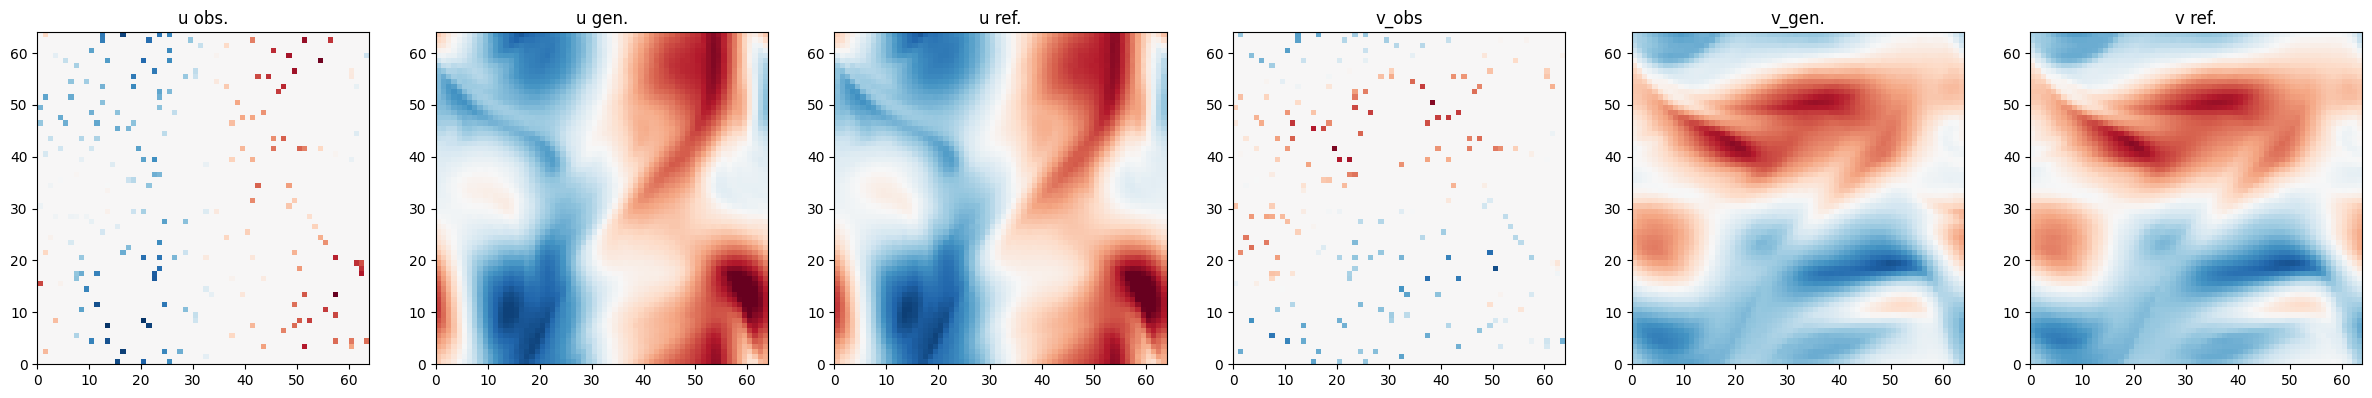

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
samples_noise = samples+std*noise_level*np.random.randn(*samples.shape)
data_plot = [y[0, :, 0], x_pred[0, :, 0], samples[0, :, 0], y[0, :, 1], x_pred[0, :, 1], samples[0, :, 1]]       # y[0, :, 0], vor_cal_batch(np.concatenate([samples_noise[0, :, 1:2], samples_noise[0, :, :1]], axis=1), config.image_size, [0, domain_size]), 
data_title = ['u obs.', 'u gen.', 'u ref.', 'v_obs', 'v_gen.', 'v ref.']   # 'obs.', 
vmins = [-3, -3, -3, -3, -3, -3]    # -3, 
vmaxs = [3, 3, 3, 3, 3, 3]      # 3, 
n_plot = len(data_plot)
def update(frame):
    plt.clf()  # Clear the current plot

    for i in range(n_plot):
        # Plot the first subplot
        plt.subplot(1, n_plot, i+1)
        plt.pcolormesh(data_plot[i][frame], cmap='RdBu_r', vmin=vmins[i], vmax=vmaxs[i])
        plt.title(data_title[i])
        plt.gca().set_aspect(1)

fig = plt.figure(figsize=(5*n_plot, 5))
ani = FuncAnimation(fig, update, frames=range(ns_real), repeat=False)
ani.save('../results/test_kol.gif', writer='pillow', fps=20)
